# Naive Machine Translation and LSH


### 1. The Word Embeddings Data for English and French Words
        
- **The Data**
    - Look at the data
    - Load two dictionaries mapping the English to French words
    - Looking at the English French dictionary

- **1.1 Generate Embedding and Transform Matrices**

### 2. Translations

#### 2.1 - Translation as Linear Transformation of Embeddings

- **Describing translation as the minimization problem**

Find a matrix `R` that minimizes the following equation. 

$$\arg \min _{\mathbf{R}}\| \mathbf{X R} - \mathbf{Y}\|_{F}\tag{1} $$

- **Frobenius norm**

The Frobenius norm of a matrix $A$ (assuming it is of dimension $m,n$) is defined as the square root of the sum of the absolute squares of its elements:

$$\|\mathbf{A}\|_{F} \equiv \sqrt{\sum_{i=1}^{m} \sum_{j=1}^{n}\left|a_{i j}\right|^{2}}\tag{2}$$
    
- Actual loss function
In the real world applications, the Frobenius norm loss:

$$\| \mathbf{XR} - \mathbf{Y}\|_{F}$$

is often replaced by it's squared value divided by $m$:

$$ \frac{1}{m} \|  \mathbf{X R} - \mathbf{Y} \|_{F}^{2}$$

where $m$ is the number of examples (rows in $\mathbf{X}$).

* The same R is found when using this loss function versus the original Frobenius norm.
* The reason for taking the square is that it's easier to compute the gradient of the squared Frobenius.
* The reason for dividing by $m$ is that we're more interested in the average loss per embedding than the  loss for the entire training set.
    * The loss for all training set increases with more words (training examples),
    so taking the average helps us to track the average loss regardless of the size of the training set.
- compute_loss
    - Computing the loss
    - compute_gradient
        - Computing the gradient of loss with respect to transform matrix R
        - Finding the optimal R with Gradient Descent Algorithm
    - align_embeddings

#### 2.2 - Testing the Translation

- k-Nearest Neighbors Algorithm

[k-Nearest neighbors algorithm](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm) 
* k-NN is a method which takes a vector as input and finds the other vectors in the dataset that are closest to it. 
* The 'k' is the number of "nearest neighbors" to find (e.g. k=2 finds the closest two neighbors).

- Searching for the Translation Embedding
Since we're approximating the translation function from English to French embeddings by a linear transformation matrix $\mathbf{R}$, most of the time we won't get the exact embedding of a French word when we transform embedding $\mathbf{e}$ of some particular English word into the French embedding space. 
* This is where $k$-NN becomes really useful! By using $1$-NN with $\mathbf{eR}$ as input, we can search for an embedding $\mathbf{f}$ (as a row) in the matrix $\mathbf{Y}$ which is the closest to the transformed vector $\mathbf{eR}$

- Cosine Similarity
Cosine similarity between vectors $u$ and $v$ calculated as the cosine of the angle between them.
The formula is 

$$\cos(u,v)=\frac{u\cdot v}{\left\|u\right\|\left\|v\right\|}$$

* $\cos(u,v)$ = $1$ when $u$ and $v$ lie on the same line and have the same direction.
* $\cos(u,v)$ is $-1$ when they have exactly opposite directions.
* $\cos(u,v)$ is $0$ when the vectors are orthogonal (perpendicular) to each other.

- nearest_neighbor
- test_vocabulary
    
### 3. LSH and Document Search

#### 3.1 - Getting the Document Embeddings**
- get_document_embedding
- get_document_vecs
#### 3.2 - Looking up the Tweets
#### 3.3 - Finding the most Similar Tweets with LSH
#### 3.4 - Getting the Hash Number for a Vector
- hash_value_of_vector
#### 3.5 - Creating a Hash Table
- make_hash_table
#### 3.6 - Creating all Hash Tables
- approximate_knn
        

In [30]:
import pdb
import pickle
import string

import time
import re

import nltk
import numpy as np
import pandas as pd
from nltk.corpus import stopwords, twitter_samples
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer

from os import getcwd

# add folder, tmp2, from our local workspace containing pre-downloaded corpora files to nltk's data path
filePath = f"{getcwd()}/tmp2/"
nltk.data.path.append(filePath)

## Function

### 1. English to french dictionary

In [2]:
def get_dict(file_name):
    """
    This function returns the english to french dictionary given a file where the each column corresponds to a word.
    Check out the files this function takes in your workspace.
    """
    my_file = pd.read_csv(file_name, delimiter=' ')
    etof = {}  # the english to french dictionary to be returned
    for i in range(len(my_file)):
        # indexing into the rows.
        en = my_file.loc[i][0]
        fr = my_file.loc[i][1]
        etof[en] = fr

    return etof

### 2. Process tweet

In [3]:
def process_tweet(tweet):
    '''
    Input:
        tweet: a string containing a tweet
    Output:
        tweets_clean: a list of words containing the processed tweet

    '''
    stemmer = PorterStemmer()
    stopwords_english = stopwords.words('english')
    # remove stock market tickers like $GE
    tweet = re.sub(r'\$\w*', '', tweet)
    # remove old style retweet text "RT"
    tweet = re.sub(r'^RT[\s]+', '', tweet)
    # remove hyperlinks
    tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet)
    # remove hashtags
    # only removing the hash # sign from the word
    tweet = re.sub(r'#', '', tweet)
    # tokenize tweets
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True,
                               reduce_len=True)
    tweet_tokens = tokenizer.tokenize(tweet)

    tweets_clean = []
    for word in tweet_tokens:
        if (word not in stopwords_english and  # remove stopwords
            word not in string.punctuation):  # remove punctuation
            # tweets_clean.append(word)
            stem_word = stemmer.stem(word)  # stemming word
            tweets_clean.append(stem_word)

    return tweets_clean

### 3. Cosine Similarity

In [4]:
def cosine_similarity(A, B):
    '''
    Input:
        A: a numpy array which corresponds to a word vector
        B: A numpy array which corresponds to a word vector
    Output:
        cos: numerical number representing the cosine similarity between A and B.
    '''
    # you have to set this variable to the true label.
    cos = -10    
    dot = np.dot(A, B)
    normb = np.linalg.norm(B)
    
    if len(A.shape) == 1: # If A is just a vector, we get the norm
        norma = np.linalg.norm(A)
        cos = dot / (norma * normb)
    else: # If A is a matrix, then compute the norms of the word vectors of the matrix (norm of each row)
        norma = np.linalg.norm(A, axis=1)
        epsilon = 1.0e-9 # to avoid division by 0
        cos = dot / (norma * normb + epsilon)
        
    return cos


### 4. Generate Embedding and Transform Matrices

Function :

```python
def get_matrices(en_fr, 
                 french_vecs, 
                 english_vecs):
```

Inputs:
- `en_fr` : English to French dictionary
- `en_embeddings` : English to embeddings dictionary
- `fr_embeddings` : French to embeddings dictionary

Return :
- Matrix `X` : each row is the word embedding for an english word
- Matrix `Y` : each same row (as X) is the word embedding for the french version word 

1. Lists of the english and french word embeddings

```python 
    X_l = list()
    Y_l = list()
```

2. Get the english words and rench words (the keys in the dictionary) and store in a set()

```python 
    english_set = english_vecs.keys()
    french_set = french_vecs.keys()
```

3. Store the french words that are part of the english-french dictionary (these are the values of the dictionary)

```python 
    french_words = set(en_fr.values())
```

4. Loop through all english, french word pairs in the english french dictionary

```python 
    for en_word, fr_word in en_fr.items():
```

5. Check that the french word has an embedding and that the english word has an embedding

```python 
        if fr_word in french_set and en_word in english_set:
```

6. Get the english embedding and french embedding

```python 
            en_vec = english_vecs[en_word]
            fr_vec = french_vecs[fr_word]
```

7. Add the english embedding and french embedding to their respectives lists

```python
            X_l.append(en_vec)
            Y_l.append(fr_vec)
```

8. Stack the vectors of X_l into a matrix X and the vectors of Y_l into a matrix Y

```python 
    X = np.vstack(X_l)
    Y = np.vstack(Y_l)
```

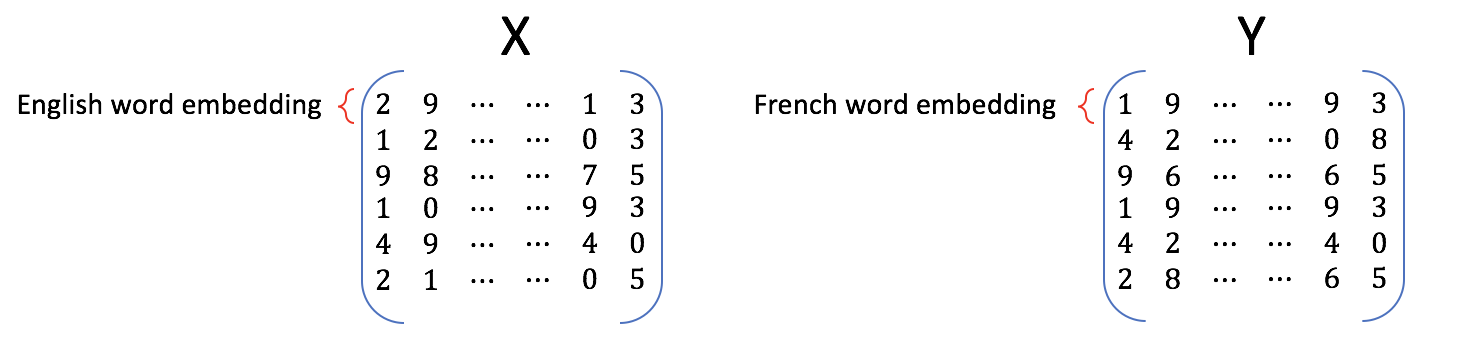

In [5]:
def get_matrices(en_fr, french_vecs, english_vecs):
    """
    Input:
        en_fr: English to French dictionary
        french_vecs: French words to their corresponding word embeddings.
        english_vecs: English words to their corresponding word embeddings.
    Output: 
        X: a matrix where the columns are the English embeddings.
        Y: a matrix where the columns correspong to the French embeddings.
        R: the projection matrix that minimizes the F norm ||X R -Y||^2.
    """
    # X_l and Y_l are lists of the english and french word embeddings
    X_l = list()
    Y_l = list()

    # get the english words (the keys in the dictionary) and store in a set()
    english_set = english_vecs.keys()

    # get the french words (keys in the dictionary) and store in a set()
    french_set = french_vecs.keys()

    # store the french words that are part of the english-french dictionary (these are the values of the dictionary)
    french_words = set(en_fr.values())

    # loop through all english, french word pairs in the english french dictionary
    for en_word, fr_word in en_fr.items():

        # check that the french word has an embedding and that the english word has an embedding
        if fr_word in french_set and en_word in english_set:

            # Get the english embedding and french embedding
            en_vec = english_vecs[en_word]
            fr_vec = french_vecs[fr_word]

            # Add the english embedding and french embedding to their respectives lists
            X_l.append(en_vec)
            Y_l.append(fr_vec)

    # stack the vectors of X_l into a matrix X
    X = np.vstack(X_l)

    # stack the vectors of Y_l into a matrix Y
    Y = np.vstack(Y_l)
    
    return X, Y

### 4. Translation as Linear Transformation of Embeddings - Computing the loss

* The loss function will be squared Frobenius norm of the difference between
matrix and its approximation, divided by the number of training examples $m$.
* Its formula is:
$$ L(X, Y, R)=\frac{1}{m}\sum_{i=1}^{m} \sum_{j=1}^{n}\left( a_{i j} \right)^{2}$$

where $a_{i j}$ is value in $i$th row and $j$th column of the matrix $\mathbf{XR}-\mathbf{Y}$.

**Function :**

```python 
def compute_loss(X, 
                 Y, 
                 R):
```

Input :
- X: a matrix of dimension `(m,n)` where the columns are the English embeddings.
- Y: a matrix of dimension `(m,n)` where the columns correspong to the French embeddings.
- R: a matrix of dimension `(n,n)` - transformation matrix from English to French vector space embeddings.

Return :
- L: a matrix of dimension (m,n) - the value of the loss function for given X, Y and R.

1. The number of rows in X
```python 
    m = X.shape[0]
```

2. Compute : XR - Y

```python 
    diff = np.dot(X,R)-Y
```

3. Compute the squarred of XR - Y

```python 
    diff_squared = diff**2
```

4. Compute sum of elements of this squarred matrix

```python 
    sum_diff_squared = np.sum(diff_squared)
```

5. Compute loss

```python 
    loss = sum_diff_squared/m
```

In [6]:
def compute_loss(X, Y, R):
    '''
    Inputs: 
        X: a matrix of dimension (m,n) where the columns are the English embeddings.
        Y: a matrix of dimension (m,n) where the columns correspong to the French embeddings.
        R: a matrix of dimension (n,n) - transformation matrix from English to French vector space embeddings.
    Outputs:
        L: a matrix of dimension (m,n) - the value of the loss function for given X, Y and R.
    '''
    # m is the number of rows in X
    m = X.shape[0]
    
    # diff is XR - Y
    diff = np.dot(X,R)-Y

    # diff_squared is the element-wise square of the difference
    diff_squared = diff**2

    # sum_diff_squared is the sum of the squared elements
    sum_diff_squared = np.sum(diff_squared)

    # loss i the sum_diff_squard divided by the number of examples (m)
    loss = sum_diff_squared/m

    return loss

### 5. Translation as Linear Transformation of Embeddings - Compute Gradient

* The formula for the gradient of the loss function $𝐿(𝑋,𝑌,𝑅)$ is:

$$\frac{d}{dR}𝐿(𝑋,𝑌,𝑅)=\frac{d}{dR}\Big(\frac{1}{m}\| X R -Y\|_{F}^{2}\Big) = \frac{2}{m}X^{T} (X R - Y)$$

**Function :**
```python 
def compute_gradient(X, 
                     Y, 
                     R):
```

**input :**
- X: a matrix of dimension (m,n) where the columns are the English embeddings.
- Y: a matrix of dimension (m,n) where the columns correspong to the French embeddings.
- R: a matrix of dimension (n,n) - transformation matrix from English to French vector space embeddings.

**Return :**

1. Compute the number of rows in X

```python 
    m = X.shape[0]
```

2. Compute gradient : X^T(XR - Y) * 2/m

```python 
    gradient = np.dot(X.transpose(),np.dot(X,R)-Y)*(2/m)
```

In [7]:
def compute_gradient(X, Y, R):
    '''
    Inputs: 
        X: a matrix of dimension (m,n) where the columns are the English embeddings.
        Y: a matrix of dimension (m,n) where the columns correspong to the French embeddings.
        R: a matrix of dimension (n,n) - transformation matrix from English to French vector space embeddings.
    Outputs:
        g: a scalar value - gradient of the loss function L for given X, Y and R.
    '''
    # m is the number of rows in X
    m = X.shape[0]

    # gradient is X^T(XR - Y) * 2/m
    gradient = np.dot(X.transpose(),np.dot(X,R)-Y)*(2/m)
    
    return gradient

### 6. Translation as Linear Transformation of Embeddings - Finding the optimal R with Gradient Descent Algorithm

Update $R$ with the formula:
$$R_{\text{new}}= R_{\text{old}}-\alpha g$$

**Function :**

```python 
def align_embeddings(X, 
                     Y, 
                     train_steps=100, 
                     learning_rate=0.0003, *
                     verbose=True, 
                     compute_loss=compute_loss, 
                     compute_gradient=compute_gradient):
```

**Input :**

- X: a matrix of dimension (m,n) where the columns are the English embeddings.
- Y: a matrix of dimension (m,n) where the columns correspong to the French embeddings.
- train_steps: positive int - describes how many steps will gradient descent algorithm do.
- learning_rate: positive float - describes how big steps will  gradient descent algorithm do.

**Return :**
- R: a matrix of dimension (n,n) - the projection matrix that minimizes the F norm ||X R -Y||^2

1. Compute a seed for random process

```python 
    np.random.seed(129)
```

2. R is a square matrix with length equal to the number of dimensions in the word embedding, the number of columns in X is the number of dimensions for a word vector (e.g. 300)

```python 
    R = np.random.rand(X.shape[1], X.shape[1])
```

3. Loop to train the model

```python 
    for i in range(train_steps):
```

4. Use the function that you defined to compute the gradient

```python 
        gradient = compute_gradient(X,Y,R)
```

5. Update R by subtracting the learning rate times gradient

```python 
        R -= learning_rate * gradient
```

In [8]:
def align_embeddings(X, Y, train_steps=100, learning_rate=0.0003, verbose=True, compute_loss=compute_loss, compute_gradient=compute_gradient):
    '''
    Inputs:
        X: a matrix of dimension (m,n) where the columns are the English embeddings.
        Y: a matrix of dimension (m,n) where the columns correspong to the French embeddings.
        train_steps: positive int - describes how many steps will gradient descent algorithm do.
        learning_rate: positive float - describes how big steps will  gradient descent algorithm do.
    Outputs:
        R: a matrix of dimension (n,n) - the projection matrix that minimizes the F norm ||X R -Y||^2
    '''
    np.random.seed(129)

    # the number of columns in X is the number of dimensions for a word vector (e.g. 300)
    # R is a square matrix with length equal to the number of dimensions in th  word embedding
    R = np.random.rand(X.shape[1], X.shape[1])

    for i in range(train_steps):
        if verbose and i % 25 == 0:
            print(f"loss at iteration {i} is: {compute_loss(X, Y, R):.4f}")
        # use the function that you defined to compute the gradient
        gradient = compute_gradient(X,Y,R)

        # update R by subtracting the learning rate times gradient
        R -= learning_rate * gradient
    return R

### 7. Testing the Translation - nearest_neighbor

* k-NN is a method which takes a vector as input and finds the other vectors in the dataset that are closest to it. 
* The 'k' is the number of "nearest neighbors" to find (e.g. k=2 finds the closest two neighbors).

**Function :**

```python 
def nearest_neighbor(v, 
                     candidates, 
                     k=1, 
                     cosine_similarity=cosine_similarity):
```

**Input :**

- v, the vector you are going find the nearest neighbor for
- candidates: a set of vectors where we will find the neighbors
- k: top k nearest neighbors to find

**Return :**
      
- k_idx: the indices of the top k closest vectors in sorted form


1. Create an empty list of similarity

```python 
    similarity_l = []
```

2. For each candidate vector get the cosine similarityand append it to the similarity list

```python 
    for row in candidates:
        cos_similarity = cosine_similarity(v,row)
        similarity_l.append(cos_similarity)
```

3. Sort the similarity list and get the indices of the sorted list  

```python 
    sorted_ids = np.argsort(similarity_l)[::-1]
```

4. Get the indices of the k most similar candidate vectors

```python 
    k_idx = sorted_ids[:k]
```

**Understand the sort**

```python
similarity_l = np.array([0.2, 0.9, 0.75, 0.4, 0.65])

sorted_ids = np.argsort(similarity_l)[::-1]

``` 

`sorted_ids = [1, 2, 4, 3, 0]`

```python
k_idx = sorted_ids[:k]
```

`k_idx = [1, 2, 4]`

In [9]:
def nearest_neighbor(v, candidates, k=1, cosine_similarity=cosine_similarity):
    """
    Input:
      - v, the vector you are going find the nearest neighbor for
      - candidates: a set of vectors where we will find the neighbors
      - k: top k nearest neighbors to find
    Output:
      - k_idx: the indices of the top k closest vectors in sorted form
    """
    similarity_l = []

    # for each candidate vector...
    for row in candidates:
        # get the cosine similarity
        cos_similarity = cosine_similarity(v,row)

        # append the similarity to the list
        similarity_l.append(cos_similarity)

    # sort the similarity list and get the indices of the sorted list    
    sorted_ids = np.argsort(similarity_l)[::-1]
    
    # get the indices of the k most similar candidate vectors
    k_idx = sorted_ids[:k]
    return k_idx

### 8. Testing the Translation - test_vocabulary

* Calculate accuracy as $$\text{accuracy}=\frac{\#(\text{correct predictions})}{\#(\text{total predictions})}$$

**Function :**

```python
def test_vocabulary(X, Y, R, nearest_neighbor=nearest_neighbor):
```

**Input :**

- X: a matrix where the columns are the English embeddings.
- Y: a matrix where the columns correspong to the French embeddings.
- R: the transform matrix which translates word embeddings from English to French word vector space.

**Return :**

- accuracy: for the English to French capitals

1. Compute prediction

```python 
    pred = np.dot(X,R)
```

2. Initialize the number correct to zero

```python 
    num_correct = 0
```

3. Loop through each row in pred (each transformed embedding)

```python 
    for i in range(len(pred)):
```

4. Get the index of the nearest neighbor of pred at row 'i'; also pass in the candidates in Y

```python 
        pred_idx = nearest_neighbor(pred[i],Y)
```

5. If the index of the nearest neighbor equals the row of i increment the number correct by 1.

```python 
        if pred_idx == i:
            num_correct += 1
```

6. Accuracy is the number correct divided by the number of rows in 'pred' (also number of rows in X)

```python 
    accuracy = num_correct / len(pred)
```

In [10]:
def test_vocabulary(X, Y, R, nearest_neighbor=nearest_neighbor):
    '''
    Input:
        X: a matrix where the columns are the English embeddings.
        Y: a matrix where the columns correspong to the French embeddings.
        R: the transform matrix which translates word embeddings from
        English to French word vector space.
    Output:
        accuracy: for the English to French capitals
    '''
    # The prediction is X times R
    pred = np.dot(X,R)

    # initialize the number correct to zero
    num_correct = 0

    # loop through each row in pred (each transformed embedding)
    for i in range(len(pred)):
        # get the index of the nearest neighbor of pred at row 'i'; also pass in the candidates in Y
        pred_idx = nearest_neighbor(pred[i],Y)

        # if the index of the nearest neighbor equals the row of i... \
        if pred_idx == i:
            # increment the number correct by 1.
            num_correct += 1

    # accuracy is the number correct divided by the number of rows in 'pred' (also number of rows in X)
    accuracy = num_correct / len(pred)

    return accuracy

### 9. Getting the Document Embeddings

#### Bag-of-words (BOW) Document Models
Text documents are sequences of words.
* The ordering of words makes a difference. For example, sentences "Apple pie is
better than pepperoni pizza." and "Pepperoni pizza is better than apple pie"
have opposite meanings due to the word ordering.
* However, for some applications, ignoring the order of words can allow
us to train an efficient and still effective model.
* This approach is called Bag-of-words document model.

**Function :**

```python
def get_document_embedding(tweet, 
                           en_embeddings, 
                           process_tweet=process_tweet
                          )
```

**Input :**

- tweet : a string
- en_embeddings : a dictionary of word embeddings

**Return :**

- doc_embedding : sum of all word embeddings in the tweet

**1. Initialize the array**

```python 
    doc_embedding = np.zeros(300)
```

**2. Process the document into a list of words (process the tweet)**

```python 
    processed_doc = process_tweet(tweet)
```

**3. Loop into the processed list of words**

```python 
    for word in processed_doc:
```

**4. Add the word embedding to the running total for the document embedding**

```python 
        doc_embedding += en_embeddings.get(word,0)
```

In [11]:
def get_document_embedding(tweet, en_embeddings, process_tweet=process_tweet):
    '''
    Input:
        - tweet: a string
        - en_embeddings: a dictionary of word embeddings
    Output:
        - doc_embedding: sum of all word embeddings in the tweet
    '''
    doc_embedding = np.zeros(300)

    # process the document into a list of words (process the tweet)
    processed_doc = process_tweet(tweet)
    for word in processed_doc:
        # add the word embedding to the running total for the document embedding
        doc_embedding += en_embeddings.get(word,0)

    return doc_embedding

### 10. Store all document vectors into a dictionary : get_document_vecs

**Function :**

```python
def get_document_vecs(all_docs, 
                      en_embeddings, 
                      get_document_embedding=get_document_embedding
                     )
```

**Input :**

- all_docs : list of strings - all tweets in our dataset.
- en_embeddings : dictionary with words as the keys and their embeddings as the values.

**Return :**

- document_vec_matrix : matrix of tweet embeddings.
- ind2Doc_dict : dictionary with indices of tweets in vecs as keys and their embeddings as the values.

**Note :**

- the dictionary's key is an index (integer) that identifies a specific tweet
- the value is the document embedding for that document

**1. Initialize the dic **

```python 
    ind2Doc_dict = {}
```

**2. Initialize the list that will store the document vectors**

```python 
    document_vec_l = []
```

**3. Loop into the processed list of words**

```python 
    for i, doc in enumerate(all_docs):
```

**4. Get the document embedding of the tweet**

```python 
        doc_embedding = get_document_embedding(doc,en_embeddings)
```

**5. Save the document embedding into the ind2Tweet dictionary at index i**

```python 
        ind2Doc_dict[i] = doc_embedding
```

**6. Append the document embedding to the list of document vectors**

```python 
        document_vec_l.append(doc_embedding)
```

**7. Convert the list of document vectors into a 2D array (each row is a document vector)

```python 
    document_vec_matrix = np.vstack(document_vec_l)
```

In [12]:
def get_document_vecs(all_docs, en_embeddings, get_document_embedding=get_document_embedding):
    '''
    Input:
        - all_docs: list of strings - all tweets in our dataset.
        - en_embeddings: dictionary with words as the keys and their embeddings as the values.
    Output:
        - document_vec_matrix: matrix of tweet embeddings.
        - ind2Doc_dict: dictionary with indices of tweets in vecs as keys and their embeddings as the values.
    '''

    # the dictionary's key is an index (integer) that identifies a specific tweet
    # the value is the document embedding for that document
    ind2Doc_dict = {}

    # this is list that will store the document vectors
    document_vec_l = []

    for i, doc in enumerate(all_docs):

        # get the document embedding of the tweet
        doc_embedding = get_document_embedding(doc,en_embeddings)

        # save the document embedding into the ind2Tweet dictionary at index i
        ind2Doc_dict[i] = doc_embedding

        # append the document embedding to the list of document vectors
        document_vec_l.append(doc_embedding)

    # convert the list of document vectors into a 2D array (each row is a document vector)
    document_vec_matrix = np.vstack(document_vec_l)

    return document_vec_matrix, ind2Doc_dict

### 11. Getting the Hash Number for a Vector

For each vector, we need to get a unique number associated to that vector in order to assign it to a "hash bucket".

#### Hyperplanes in Vector Spaces
* In $3$-dimensional vector space, the hyperplane is a regular plane. In $2$ dimensional vector space, the hyperplane is a line.
* Generally, the hyperplane is subspace which has dimension $1$ lower than the original vector space has.
* A hyperplane is uniquely defined by its normal vector.
* Normal vector $n$ of the plane $\pi$ is the vector to which all vectors in the plane $\pi$ are orthogonal (perpendicular in $3$ dimensional case).

#### Using Hyperplanes to Split the Vector Space
We can use a hyperplane to split the vector space into $2$ parts.
* All vectors whose dot product with a plane's normal vector is positive are on one side of the plane.
* All vectors whose dot product with the plane's normal vector is negative are on the other side of the plane.

#### Encoding Hash Buckets
* For a vector, we can take its dot product with all the planes, then encode this information to assign the vector to a single hash bucket.
* When the vector is pointing to the opposite side of the hyperplane than normal, encode it by 0.
* Otherwise, if the vector is on the same side as the normal vector, encode it by 1.
* If you calculate the dot product with each plane in the same order for every vector, you've encoded each vector's unique hash ID as a binary number, like [0, 1, 1, ... 0].

$$ hash = \sum_{i=0}^{N-1} \left( 2^{i} \times h_{i} \right) $$

**Function :**

```python
def hash_value_of_vector(v, 
                         planes
                        )
```

**Input :**

- v : vector of tweet. It's dimension is (1, N_DIMS)
- planes : matrix of dimension (N_DIMS, N_PLANES) - the set of planes that divide up the region

**Return :**

- res: a number which is used as a hash for your vector

**1. Dot product between the vector and the matrix containing the planes **
- remember that planes has shape (300, 10)
- The dot product will have the shape (1,10)  
```python 
    dot_product = np.dot(v, planes)
```

**2. Get the sign of the dot product**

```python 
    sign_of_dot_product = np.sign(dot_product)
```

**3. Initialize h with the sign of the dot product**
- set h to be false (eqivalent to 0 when used in operations) if the sign is negative, and true (equivalent to 1) if the sign is positive (1,10) shaped vector
- if the sign is 0, i.e. the vector is in the plane, consider the sign to be positive

```python 
    h = sign_of_dot_product>=0
```

**4. Remove extra un-used dimensions (convert this from a 2D to a 1D array)**

```python 
    h = np.squeeze(h)
```

**5. Initialize the hash value to 0**

```python 
    hash_value = 0
```

**6. Define the number of planes**

```python 
    n_planes = planes.shape[1]
```

**7. Loop through all planes**

```python 
    for i in range(n_planes):
```

**8. Increment the hash value by 2^i * h_i **

```python 
        hash_value += np.power(2,i)*h[i]
```

**7. Cast hash_value as an integer**

```python 
    hash_value = int(hash_value)
```


In [13]:
def hash_value_of_vector(v, planes):
    """Create a hash for a vector; hash_id says which random hash to use.
    Input:
        - v:  vector of tweet. It's dimension is (1, N_DIMS)
        - planes: matrix of dimension (N_DIMS, N_PLANES) - the set of planes that divide up the region
    Output:
        - res: a number which is used as a hash for your vector

    """ 
    dot_product = np.dot(v, planes)
    
    # Get the sign of the dot product
    sign_of_dot_product = np.sign(dot_product)

    # set h to be false (eqivalent to 0 when used in operations) if the sign is negative,
    # and true (equivalent to 1) if the sign is positive (1,10) shaped vector
    # if the sign is 0, i.e. the vector is in the plane, consider the sign to be positive
    h = sign_of_dot_product>=0

    # remove extra un-used dimensions (convert this from a 2D to a 1D array)
    h = np.squeeze(h)

    # initialize the hash value to 0
    hash_value = 0

    n_planes = planes.shape[1]
    for i in range(n_planes):
        # increment the hash value by 2^i * h_i        
        hash_value += np.power(2,i)*h[i]
        
    # cast hash_value as an integer
    hash_value = int(hash_value)

    return hash_value

### 12. Creating a Hash Table

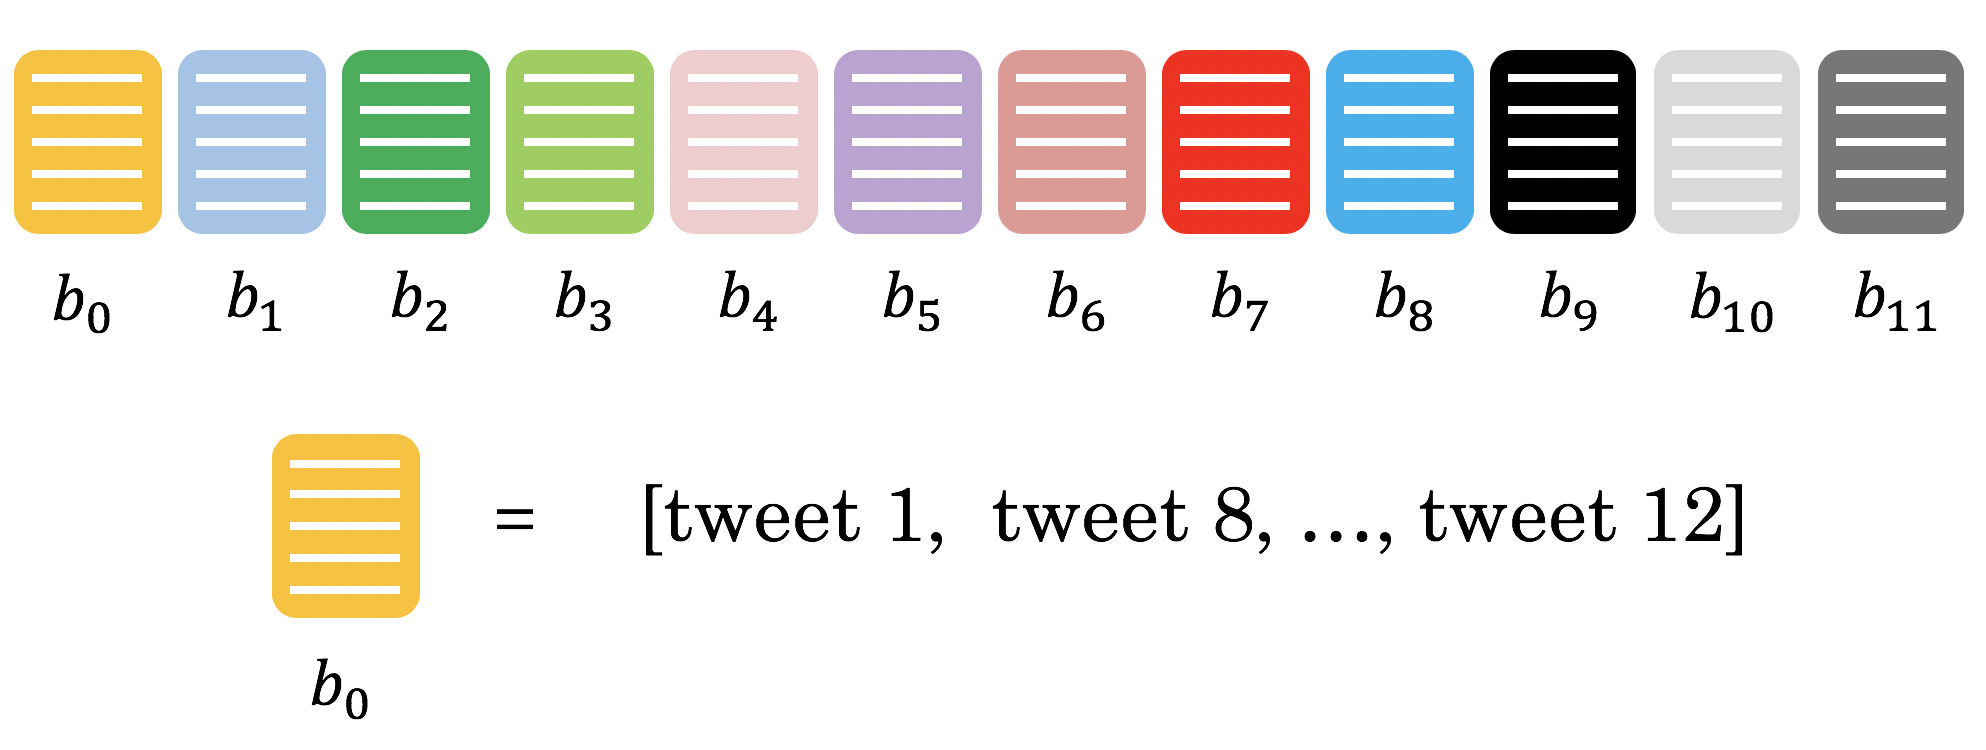

In [14]:
# UNQ_C19 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)

# This is the code used to create a hash table: 
# This function is already implemented for you. Feel free to read over it.

### YOU CANNOT EDIT THIS CELL

def make_hash_table(vecs, planes, hash_value_of_vector=hash_value_of_vector):
    """
    Input:
        - vecs: list of vectors to be hashed.
        - planes: the matrix of planes in a single "universe", with shape (embedding dimensions, number of planes).
    Output:
        - hash_table: dictionary - keys are hashes, values are lists of vectors (hash buckets)
        - id_table: dictionary - keys are hashes, values are list of vectors id's
                            (it's used to know which tweet corresponds to the hashed vector)
    """
    # number of planes is the number of columns in the planes matrix
    num_of_planes = planes.shape[1]

    # number of buckets is 2^(number of planes)
    # ALTERNATIVE SOLUTION COMMENT:
    # num_buckets = pow(2, num_of_planes)
    num_buckets = 2**num_of_planes

    # create the hash table as a dictionary.
    # Keys are integers (0,1,2.. number of buckets)
    # Values are empty lists
    hash_table = {i: [] for i in range(num_buckets)}

    # create the id table as a dictionary.
    # Keys are integers (0,1,2... number of buckets)
    # Values are empty lists
    id_table = {i: [] for i in range(num_buckets)}

    # for each vector in 'vecs'
    for i, v in enumerate(vecs):
        # calculate the hash value for the vector
        h = hash_value_of_vector(v, planes)

        # store the vector into hash_table at key h,
        # by appending the vector v to the list at key h
        hash_table[h].append(v) # @REPLACE None

        # store the vector's index 'i' (each document is given a unique integer 0,1,2...)
        # the key is the h, and the 'i' is appended to the list at key h
        id_table[h].append(i) # @REPLACE None

    return hash_table, id_table

### 13. Creating all Hash Tables


In [15]:
def create_hash_id_tables(n_universes):
    hash_tables = []
    id_tables = []
    for universe_id in range(n_universes):  # there are 25 hashes
        print('working on hash universe #:', universe_id)
        planes = planes_l[universe_id]
        hash_table, id_table = make_hash_table(document_vecs, planes)
        hash_tables.append(hash_table)
        id_tables.append(id_table)
    
    return hash_tables, id_tables

### 14. Approximate knn

In [16]:
def approximate_knn(doc_id, v, planes_l, hash_tables, id_tables, k=1, num_universes_to_use=25, hash_value_of_vector=hash_value_of_vector):
    """Search for k-NN using hashes."""
    #assert num_universes_to_use <= N_UNIVERSES

    # Vectors that will be checked as possible nearest neighbor
    vecs_to_consider_l = list()

    # list of document IDs
    ids_to_consider_l = list()

    # create a set for ids to consider, for faster checking if a document ID already exists in the set
    ids_to_consider_set = set()

    # loop through the universes of planes
    for universe_id in range(num_universes_to_use):

        # get the set of planes from the planes_l list, for this particular universe_id
        planes = planes_l[universe_id]

        # get the hash value of the vector for this set of planes
        hash_value = hash_value_of_vector(v, planes)

        # get the hash table for this particular universe_id
        hash_table = hash_tables[universe_id]

        # get the list of document vectors for this hash table, where the key is the hash_value
        document_vectors_l = hash_table[hash_value]

        # get the id_table for this particular universe_id
        id_table = id_tables[universe_id]

        # get the subset of documents to consider as nearest neighbors from this id_table dictionary
        new_ids_to_consider = id_table[hash_value]

        # loop through the subset of document vectors to consider
        for i, new_id in enumerate(new_ids_to_consider):
            
            if doc_id == new_id:
                continue

            # if the document ID is not yet in the set ids_to_consider...
            if new_id not in ids_to_consider_set:
                # access document_vectors_l list at index i to get the embedding
                # then append it to the list of vectors to consider as possible nearest neighbors
                document_vector_at_i = document_vectors_l[i]

                # append the new_id (the index for the document) to the list of ids to consider
                vecs_to_consider_l.append(document_vector_at_i)
                ids_to_consider_l.append(new_id)

                # also add the new_id to the set of ids to consider
                # (use this to check if new_id is not already in the IDs to consider)
                ids_to_consider_set.add(new_id)

    # Now run k-NN on the smaller set of vecs-to-consider.
    print("Fast considering %d vecs" % len(vecs_to_consider_l))

    # convert the vecs to consider set to a list, then to a numpy array
    vecs_to_consider_arr = np.array(vecs_to_consider_l)

    # call nearest neighbors on the reduced list of candidate vectors
    nearest_neighbor_idx_l = nearest_neighbor(v, vecs_to_consider_arr, k=k)

    # Use the nearest neighbor index list as indices into the ids to consider
    # create a list of nearest neighbors by the document ids
    nearest_neighbor_ids = [ids_to_consider_l[idx]
                            for idx in nearest_neighbor_idx_l]

    return nearest_neighbor_ids

## 1. The Word Embeddings Data for English and French Words

In [20]:
en_embeddings_subset = pickle.load(open("./data/en_embeddings.p", "rb"))
fr_embeddings_subset = pickle.load(open("./data/fr_embeddings.p", "rb"))

print(fr_embeddings_subset)

# loading the english to french dictionaries
en_fr_train = get_dict('./data/en-fr.train.txt')
print('The length of the English to French training dictionary is', len(en_fr_train))
en_fr_test = get_dict('./data/en-fr.test.txt')
print('The length of the English to French test dictionary is', len(en_fr_test))

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



The length of the English to French training dictionary is 5000
The length of the English to French test dictionary is 1500


In [23]:
# getting the training set:
X_train, Y_train = get_matrices(
    en_fr_train, fr_embeddings_subset, en_embeddings_subset)

## 2. Translations

In [24]:
# Calculate R

R_train = align_embeddings(X_train, Y_train, train_steps=400, learning_rate=0.8)

loss at iteration 0 is: 963.0146
loss at iteration 25 is: 97.8292
loss at iteration 50 is: 26.8329
loss at iteration 75 is: 9.7893
loss at iteration 100 is: 4.3776
loss at iteration 125 is: 2.3281
loss at iteration 150 is: 1.4480
loss at iteration 175 is: 1.0338
loss at iteration 200 is: 0.8251
loss at iteration 225 is: 0.7145
loss at iteration 250 is: 0.6534
loss at iteration 275 is: 0.6185
loss at iteration 300 is: 0.5981
loss at iteration 325 is: 0.5858
loss at iteration 350 is: 0.5782
loss at iteration 375 is: 0.5735


In [25]:
# Test accuracy

X_val, Y_val = get_matrices(en_fr_test, fr_embeddings_subset, en_embeddings_subset)

acc = test_vocabulary(X_val, Y_val, R_train)  # this might take a minute or two
print(f"accuracy on test set is {acc:.3f}")

accuracy on test set is 0.557


## 3. LSH and document search

In [31]:
# get the positive and negative tweets
all_positive_tweets = twitter_samples.strings('positive_tweets.json')
all_negative_tweets = twitter_samples.strings('negative_tweets.json')
all_tweets = all_positive_tweets + all_negative_tweets

custom_tweet = "RT @Twitter @chapagain Hello There! Have a great day. :) #good #morning http://chapagain.com.np"
tweet_embedding = get_document_embedding(custom_tweet, en_embeddings_subset)
tweet_embedding[-5:]

array([-0.00268555, -0.15378189, -0.55761719, -0.07216644, -0.32263184])

In [33]:
document_vecs, ind2Tweet = get_document_vecs(all_tweets, en_embeddings_subset)
print(f"length of dictionary {len(ind2Tweet)}")
print(f"shape of document_vecs {document_vecs.shape}")

my_tweet = 'i am sad'
process_tweet(my_tweet)
tweet_embedding = get_document_embedding(my_tweet, en_embeddings_subset)

idx = np.argmax(cosine_similarity(document_vecs, tweet_embedding))
print(all_tweets[idx])

length of dictionary 10000
shape of document_vecs (10000, 300)
@hanbined sad pray for me :(((


In [36]:
N_VECS = len(all_tweets)       # This many vectors.
N_DIMS = len(ind2Tweet[1])     # Vector dimensionality.
print(f"Number of vectors is {N_VECS} and each has {N_DIMS} dimensions.")

# The number of planes. We use log2(625) to have ~16 vectors/bucket.
N_PLANES = 10
# Number of times to repeat the hashing to improve the search.
N_UNIVERSES = 25

np.random.seed(0)
planes_l = [np.random.normal(size=(N_DIMS, N_PLANES))
            for _ in range(N_UNIVERSES)]

np.random.seed(0)
idx = 0
planes = planes_l[idx]  # get one 'universe' of planes to test the function
vec = np.random.rand(1, 300)
print(f" The hash value for this vector,",
      f"and the set of planes at index {idx},",
      f"is {hash_value_of_vector(vec, planes)}")



Number of vectors is 10000 and each has 300 dimensions.
 The hash value for this vector, and the set of planes at index 0, is 768


In [37]:
planes = planes_l[0]  # get one 'universe' of planes to test the function
tmp_hash_table, tmp_id_table = make_hash_table(document_vecs, planes)

print(f"The hash table at key 0 has {len(tmp_hash_table[0])} document vectors")
print(f"The id table at key 0 has {len(tmp_id_table[0])} document indices")
print(f"The first 5 document indices stored at key 0 of id table are {tmp_id_table[0][0:5]}")

The hash table at key 0 has 3 document vectors
The id table at key 0 has 3 document indices
The first 5 document indices stored at key 0 of id table are [3276, 3281, 3282]


In [40]:
hash_tables, id_tables = create_hash_id_tables(N_UNIVERSES)

#document_vecs, ind2Tweet
doc_id = 0
doc_to_search = all_tweets[doc_id]
vec_to_search = document_vecs[doc_id]

# Sample
nearest_neighbor_ids = approximate_knn(
    doc_id, vec_to_search, planes_l, hash_tables, id_tables, k=3, num_universes_to_use=5)

print(f"Nearest neighbors for document {doc_id}")
print(f"Document contents: {doc_to_search}")
print("")

for neighbor_id in nearest_neighbor_ids:
    print(f"Nearest neighbor at document id {neighbor_id}")
    print(f"document contents: {all_tweets[neighbor_id]}")
    


working on hash universe #: 0
working on hash universe #: 1
working on hash universe #: 2
working on hash universe #: 3
working on hash universe #: 4
working on hash universe #: 5
working on hash universe #: 6
working on hash universe #: 7
working on hash universe #: 8
working on hash universe #: 9
working on hash universe #: 10
working on hash universe #: 11
working on hash universe #: 12
working on hash universe #: 13
working on hash universe #: 14
working on hash universe #: 15
working on hash universe #: 16
working on hash universe #: 17
working on hash universe #: 18
working on hash universe #: 19
working on hash universe #: 20
working on hash universe #: 21
working on hash universe #: 22
working on hash universe #: 23
working on hash universe #: 24
Fast considering 77 vecs
Nearest neighbors for document 0
Document contents: #FollowFriday @France_Inte @PKuchly57 @Milipol_Paris for being top engaged members in my community this week :)

Nearest neighbor at document id 51
document c

python 

```python 

```

